# Projects in AI and ML HW6 Task 4 (Grad Task)

Implement the game of tic-tac-toe (write a class that implements an agent
playing Tic Tac Toe and learning its Q function) using the Q-learning technique (see the
resources/links provided in class for more details). Clearly describe your evaluation metric and
demonstrate a few runs. You might need to use some online resources to proceed with this. Do
not forget to cite those.

https://towardsdatascience.com/reinforcement-learning-q-learning-with-illegal-actions-from-scratch-19759146c8bf/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# define the locations
actionNames = {
    0: "(0, 0) Upper Left",
    1: "(1, 0) Upper Center",
    2: "(2, 0) Upper Right",
    3: "(0, 1) Middle Left",
    4: "(1, 1) Middle Center",
    5: "(2, 1) Middle Right",
    6: "(0, 2) Lower Left",
    7: "(1, 2) Lower Center",
    8: "(2, 2) Lower Right",
}

actions = actionNames.keys()

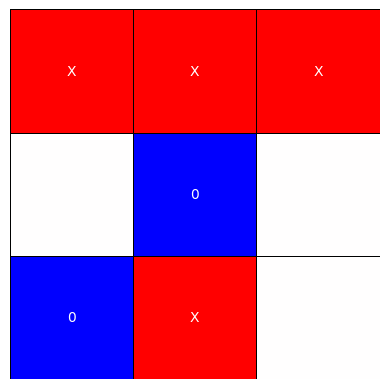

In [4]:
# Draw the board
def drawBoard(board, saveName=None):
    labelMap = np.vectorize(lambda value: {1:"X", -1:"0", 0:" "}[value])
    shapedBoard = np.reshape(board, (3, 3))
    labels = labelMap(shapedBoard)
    sns.heatmap(shapedBoard, cmap="bwr", annot=labels,
        linewidth=.5, linecolor="black", fmt="", cbar=False,
        square=True, xticklabels=False, yticklabels=False, vmin=-1, vmax=1)
    if saveName:
        plt.savefig(f"figs/{saveName}")

#Testing
drawBoard([1, 1, 1, 0, -1, 0, -1, 1, 0])

In [5]:
boardToState = {}

class GameStateNode():
    def __init__(self):
        #self.winner is who won, X or O, else is None if draw or not leaf node
        self.winner = 0
        self.children = {}
        #The board representation as an array of 9 positions
        self.board = None

#There are only 8 win cases, defining them here
winMasks = np.array([
    [1, 1, 1, 0, 0, 0, 0, 0, 0], #Horizontal wins
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 1, 0, 0], #Vertical Wins
    [0, 1, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 1], #Diagonal wins
    [0, 0, 1, 0, 1, 0, 1, 0, 0]
])

def win(board):
    for winMask in winMasks:
        maskedSum = np.sum(winMask*board)
        if maskedSum == 3:
            return 1
        elif maskedSum == -3:
            return -1
    return 0


def buildGameTree(node, board, player):
    node.winner = win(board)
    if node.winner:
        return
    for action in actions:
        if board[action] == 0:  #if move is legal
            newBoard = np.copy(board)
            newBoard[action] = player
            newBoard.flags.writeable = False
            # Reuse trees for states we've already seen
            if newBoard.tobytes() in boardToState:
                newNode = boardToState[newBoard.tobytes()]
            # Create new tree if we have not seen it
            else:
                newNode = GameStateNode()
                newNode.board = newBoard
                buildGameTree(newNode, newBoard, -player)
                boardToState[newBoard.tobytes()] = newNode
            node.children[action] = newNode

In [6]:
root = GameStateNode()
emptyBoard = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
boardToState[emptyBoard.tobytes()] = root
root.board = emptyBoard
buildGameTree(root, emptyBoard, 1)
len(boardToState)

5478

In [8]:
# Map board states to Q-Table indices
boardToQIndex = {b:i for i, (b, _) in enumerate(boardToState.items())}
qTable = None

def initQTable():
    global qTable
    #create Q-Table full of NaNs with shape numStates x numActions
    qTable = np.full((len(boardToQIndex), len(actions)), np.nan)

    #fill legal Q-table actions with 0s
    for board, state in boardToState.items():
        for action, _ in state.children.items():
            qTable[boardToQIndex[board], action] = 0

initQTable()
print(qTable[-10:, :])

[[ 0.  0.  0.  0.  0.  0.  0. nan  0.]
 [nan  0.  0.  0.  0.  0.  0.  0. nan]
 [ 0. nan  0.  0.  0.  0.  0.  0. nan]
 [ 0.  0. nan  0.  0.  0.  0.  0. nan]
 [ 0.  0.  0. nan  0.  0.  0.  0. nan]
 [ 0.  0.  0.  0. nan  0.  0.  0. nan]
 [ 0.  0.  0.  0.  0. nan  0.  0. nan]
 [ 0.  0.  0.  0.  0.  0. nan  0. nan]
 [ 0.  0.  0.  0.  0.  0.  0. nan nan]
 [ 0.  0.  0.  0.  0.  0.  0.  0. nan]]


In [9]:
#Hyperparameters:
learningRate = 0.1
discountFactor = 0.9
epsilon = 0.2

#Run the agent for a number of episodes
def run(numEpisodes, training = True, saveGames = False):
    global qTable
    player = 1
    winner = []
    if training:
        initQTable()
    savedGames = None
    if saveGames:
        savedGames = []
    for episode in range(numEpisodes):
        player = -player
        if episode % 1000 == 0:
            print(episode, end=" ")
        curState = root
        if saveGames:
            savedGame = [curState.board]
        if player == -1:
            curState = np.random.choice(list(curState.children.values()))
            if saveGames:
                savedGame.append(curState.board)

        while True:
            #RL Agent's Turn
            # Select action based on Exploration vs Exploitation
            # Exploration, choose random action
            # Exploitation, choose based on best Q-Value
            if training and np.random.uniform() < epsilon:
                action = np.random.choice(list(curState.children.keys()))
            else:
                action = np.nanargmax(qTable[boardToQIndex[curState.board.tobytes()], :])
            #Update Q-Table
            nextState = curState.children[action]
            if training:
                Qsa = qTable[boardToQIndex[curState.board.tobytes()], action]
                # Hitting a win state
                if len(nextState.children) == 0:
                    reward = 0.1 if nextState.winner == 0 else nextState.winner*player
                    newQsa = Qsa + learningRate*(reward - Qsa)
                    qTable[boardToQIndex[curState.board.tobytes()], action] = newQsa #Update our Q-table
                    winner.append(("RL", player, 0 if nextState.winner == 0 else player))
                    break
                else:
                    futureValues = set()
                    for _, state in nextState.children.items():
                        if len(state.children) == 0:
                            futureValues.add(0)
                        else:
                            futureValue = np.nanmax(qTable[boardToQIndex[state.board.tobytes()], :])
                            futureValues.add(futureValue)
                    optimalFutureValue = max(futureValues)
                    newQsa = Qsa + learningRate*(discountFactor*optimalFutureValue - Qsa)
                    qTable[boardToQIndex[curState.board.tobytes()], action] = newQsa #Update our Q-table
            else:
                if saveGames:
                    savedGame.append(nextState.board)
                if len(nextState.children) == 0:
                    if saveGames:
                        savedGames.append(savedGame)
                    winner.append(("RL", player, 0 if nextState.winner == 0 else player))
                    break

            curState = nextState

            #Random Agents turn
            curState = np.random.choice(list(curState.children.values()))
            if saveGames:
                savedGame.append(curState.board)
            if len(curState.children) == 0:
                if saveGames:
                    savedGames.append(savedGame)
                winner.append(("Rand", -player, 0 if curState.winner == 0 else -player))
                break
    print("\n")
    return winner, savedGames

In [10]:
trainingEpisodes = 250000
testingEpisodes = 5000
trainingWinners, _ = run(trainingEpisodes)
testingWinners, _ = run(testingEpisodes, False)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000 152000 153000 154000 155000 156000 157000 158000 

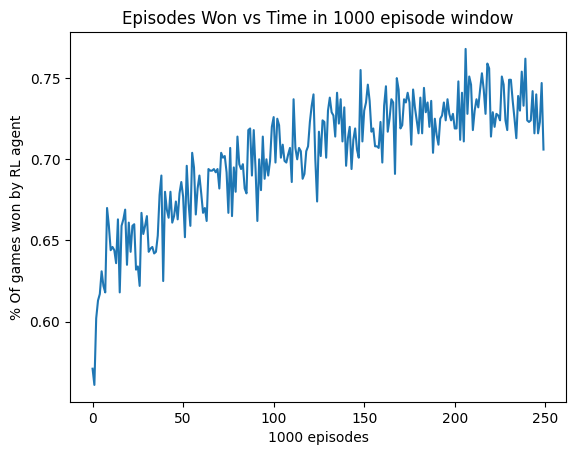

In [11]:
import matplotlib.pyplot as plt

window = 1000

average = []
for start in range(0, trainingEpisodes, window):
    count = 0
    for (name, player, winner) in trainingWinners[start:start+window]:
        if name == "RL" and winner != 0:
            count += 1
    average.append(count / window)

plt.title(f"Episodes Won vs Time in {window} episode window")
plt.xlabel(f"{window} episodes")
plt.ylabel(f"% Of games won by RL agent")
plt.plot(average)

We can see from above that the percentage of games won by the RL agent increases with the increase of episodes, showing it is learning.

In [12]:
np.set_printoptions(2, suppress=True)
print("End of Q-Table")
print(qTable[-15:,:])
print("===============")
print("Start of Q-Table")
print(qTable[:15,:])

End of Q-Table
[[0.81 0.17 0.02 0.06 0.04  nan 0.03  nan  nan]
 [0.81 0.49 0.34 0.08 0.14  nan 0.2   nan 0.26]
 [0.9  0.16 0.   0.05 0.27 0.03  nan  nan  nan]
 [0.81 0.35 0.37 0.08 0.13 0.05  nan  nan 0.2 ]
 [0.81 0.28 0.17 0.08 0.15 0.05 0.14  nan  nan]
 [0.81 0.81 0.81 0.81 0.81 0.73 0.81  nan 0.81]
 [ nan 0.72 0.14 0.07 0.03 0.19 0.01 0.18  nan]
 [0.9   nan 0.19 0.23 0.17 0.24 0.2  0.24  nan]
 [0.9  0.2   nan 0.16 0.24 0.16 0.2  0.13  nan]
 [0.9  0.31 0.18  nan 0.17 0.19 0.1  0.11  nan]
 [0.81 0.3  0.26 0.24  nan 0.14 0.1  0.1   nan]
 [0.9  0.16 0.28 0.15 0.28  nan 0.08 0.07  nan]
 [0.9  0.25 0.16 0.04 0.19 0.18  nan 0.18  nan]
 [0.9  0.29 0.2  0.13 0.21 0.21 0.22  nan  nan]
 [0.81 0.81 0.81 0.81 0.73 0.73 0.81 0.81  nan]]
Start of Q-Table
[[0.81 0.81 0.81 0.73 0.81 0.73 0.81 0.79 0.81]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan 1.  ]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan 

The above code visualizes the Q table.

In [13]:
def evaluate(winners, numEpisodes):
    drawRL = winners.count(("RL", 1, 0)) + winners.count(("Rand", -1, 0))
    drawRand = winners.count(("RL", -1, 0)) + winners.count(("Rand", 1, 0))
    draws = drawRL + drawRand
    print(f"Draws: {draws} ({(draws)/numEpisodes*100:.2f}%)")
    print(f"\tRL Draws as X: {drawRL} ({(drawRL)/numEpisodes*100:.2f}%)")
    print(f"\tRL Draws as O: {drawRand} ({(drawRand)/numEpisodes*100:.2f}%)")
    rlx = winners.count(("RL", 1, 1))
    rlo = winners.count(("RL", -1, -1))
    print(f"RL Wins: {rlx + rlo} ({(rlx + rlo)/numEpisodes*100:.2f}%)")
    print(f"\tRL Wins as X: {rlx} ({rlx/numEpisodes*100:.2f}%)")
    print(f"\tRL Wins as O: {rlo} ({rlo/numEpisodes*100:.2f}%)")
    rx = winners.count(("Rand", 1, 1))
    ro = winners.count(("Rand", -1, -1))
    print(f"Rand Wins: {rx + ro} ({(rx + ro)/numEpisodes*100:.2f}%)")
    print(f"\tRand Wins as X: {rx} ({rx/numEpisodes*100:.2f}%)")
    print(f"\tRand Wins as O: {ro} ({ro/numEpisodes*100:.2f}%)")

print("During Training (With 20% random actions):")
evaluate(trainingWinners, trainingEpisodes)
print("Testing (After training, Always selecting best action):")
evaluate(testingWinners, testingEpisodes)

During Training (With 20% random actions):
Draws: 11115 (4.45%)
	RL Draws as X: 6076 (2.43%)
	RL Draws as O: 5039 (2.02%)
RL Wins: 175520 (70.21%)
	RL Wins as X: 102903 (41.16%)
	RL Wins as O: 72617 (29.05%)
Rand Wins: 63365 (25.35%)
	Rand Wins as X: 47344 (18.94%)
	Rand Wins as O: 16021 (6.41%)
Testing (After training, Always selecting best action):
Draws: 112 (2.24%)
	RL Draws as X: 91 (1.82%)
	RL Draws as O: 21 (0.42%)
RL Wins: 4224 (84.48%)
	RL Wins as X: 2287 (45.74%)
	RL Wins as O: 1937 (38.74%)
Rand Wins: 664 (13.28%)
	Rand Wins as X: 542 (10.84%)
	Rand Wins as O: 122 (2.44%)


The above shows the evaluation of running the game. Its performance is seen as percentage of wins. It can be seen that the RL agent wins the majority of the time.